<a href="https://colab.research.google.com/github/saswata0502/Workplace-Jarvis-Meeting-Task-Assistant/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 6120 Final Project: Workplace “Jarvis” – Meeting & Task Assistant

**Authors:** Ishika Gupta (21601), Vaishnavi Hemal Jariwala (21600), Saswata Lahiri (21600), Catherine Hoffmann (21600)

**Course:** CS 6120 -- Natural Language Processing

**Overview**

In most workplace environments, meeting summaries and action items are either manually recorded or not tracked efficiently, leading to miscommunication and a lack of accountability. Our goal is to develop an NLP-based assistant that can automatically process meeting transcripts and generate structured outputs, including agendas, key decisions, and actionable tasks with assigned responsibilities. By combining summarization, named entity recognition, and relation extraction, our system will help reduce manual effort and improve productivity.

## Phase 1: Data Exploration

### 1.1: Corpora Parsing and Exploration

This phase loads, parses, and explores the AMI and ICSI meeting corpora.  Collectively, the datasets contain XML files representing over 170 hours of raw meeting transcripts, annotated with meeting and speaker identifications as well as start and end time markers.  

Sources: https://groups.inf.ed.ac.uk/ami/ and https://groups.inf.ed.ac.uk/ami/icsi/.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Define project and dataset paths inside your Shared Drive
PROJECT_PATH = "/content/drive/Shareddrives/NLP_FinalProject"
AMI_PATH = f"{PROJECT_PATH}/AMI_XML/words"
ICSI_PATH = f"{PROJECT_PATH}/ICSI_XML/ICSI/Words"

# Verify the folders exist
import os
for path in [PROJECT_PATH, AMI_PATH, ICSI_PATH]:
    print("Found:" if os.path.exists(path) else "Missing:", path)

Found: /content/drive/Shareddrives/NLP_FinalProject
Found: /content/drive/Shareddrives/NLP_FinalProject/AMI_XML/words
Found: /content/drive/Shareddrives/NLP_FinalProject/ICSI_XML/ICSI/Words


In [ ]:
import os, html, re, xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")

# --- Environment setup (using CPU for now) ---
import torch
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
torch.set_default_device("cpu")
print("Training on device:", torch.device("cpu"))

# --- Parse each Corpus ---
def parse_meeting_words(folder):
    """Parse .words.xml files to extract meeting_id, speaker, transcript."""
    records = []
    for root, _, files in os.walk(folder):
        for f in files:
            if not f.endswith(".words.xml"):
                continue

            file_path = os.path.join(root, f)
            m = re.match(r"([A-Za-z0-9]+)\.([A-Za-z])\.words\.xml", f)
            if m:
                meeting_id, speaker = m.groups()
            else:
                meeting_id, speaker = f.replace(".words.xml", ""), "?"

            try:
                tree = ET.parse(file_path)
                root_elem = tree.getroot()
                words = [w.text for w in root_elem.iter() if w.text]
                if not words:
                    continue

                text = " ".join(words)
                text = html.unescape(text)
                text = re.sub(r"\s+", " ", text).strip()
                if len(text) > 30:
                    records.append({"meeting_id": meeting_id, "speaker": speaker, "transcript": text})

            except ET.ParseError as e:
                print(f"XML parse error in {f}: {e}")
            except Exception as e:
                print(f"Unexpected error parsing {f}: {e}")

    df = pd.DataFrame(records)
    print(f"Parsed {len(df)} utterances from {folder}")
    return df

ami_df = parse_meeting_words(AMI_PATH)
icsi_df = parse_meeting_words(ICSI_PATH)


for df, name in [(ami_df, "AMI"), (icsi_df, "ICSI")]:
    print(f"{name} columns:", df.columns.tolist())
    print(f"{name} shape:", df.shape)

Training on device: cpu
Parsed 682 utterances from /content/drive/Shareddrives/NLP_FinalProject/AMI_XML/words
Parsed 489 utterances from /content/drive/Shareddrives/NLP_FinalProject/ICSI_XML/ICSI/Words
AMI columns: ['meeting_id', 'speaker', 'transcript']
AMI shape: (682, 3)
ICSI columns: ['meeting_id', 'speaker', 'transcript']
ICSI shape: (489, 3)


In [ ]:
# --- Distribution of transcript lengths ---
ami_df["word_count"] = ami_df["transcript"].apply(lambda x: len(str(x).split()))
icsi_df["word_count"] = icsi_df["transcript"].apply(lambda x: len(str(x).split()))

summary = pd.DataFrame({
    "Corpus": ["AMI", "ICSI"],
    "Meetings": [ami_df["meeting_id"].nunique(), icsi_df["meeting_id"].nunique()],
    "Speakers": [ami_df["speaker"].nunique(), icsi_df["speaker"].nunique()],
    "Utterances": [len(ami_df), len(icsi_df)],
    "Avg Words per Turn": [ami_df["word_count"].mean(), icsi_df["word_count"].mean()]
})

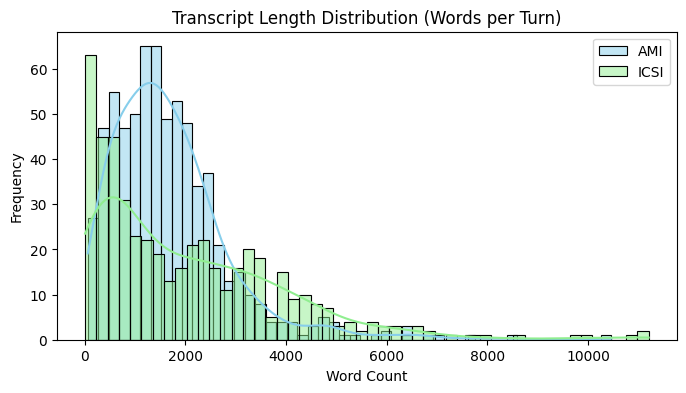

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(ami_df["word_count"], bins=50, color='skyblue', label='AMI', kde=True)
sns.histplot(icsi_df["word_count"], bins=50, color='lightgreen', label='ICSI', kde=True)
plt.legend()
plt.title("Transcript Length Distribution (Words per Turn)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
display(summary)

,Corpus,Meetings,Speakers,Utterances,Avg Words per Turn
0,AMI,171,5,682,1682.966276
1,ICSI,76,11,489,2053.079755


### 1.2 — Data Cleaning & Normalization

This phase cleans the dataset -- removing formatting tags, non-informative punctuation, extra whitespace, and stop words -- and then normalizes the data by lowercasing all letters.  

We chose to keep the following punctuation: **. , ? ! ' "** as these marks carry meaningful semantic cues that can be used as potential indicators of a particular type of action item and to preserve natural language structure.

In [ ]:
FILLERS = ["uh", "um", "mmm", "mm", "hmm", "huh", "ah", "er", "eh", "oh", "ha",
"ha-ha", "mhm", "mm-hmm", "uh-huh", "yeah", "yep", "ok", "okay",
"alright", "right", "uhuh", "huhuh", "hmmm", "mmmmm"]


def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    # Remove XML-like tags such as <s>, <w>, etc.
    text = re.sub(r"<[^>]+>", " ", text)
    # Keep letters, numbers, and common punctuation
    text = re.sub(r"[^\w\s.,?!'\"-]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text



def remove_fillers(text):
  if not isinstance(text, str):
    return ""
  text = re.sub(rf"\b({'|'.join(FILLERS)})\b", " ", text, flags=re.IGNORECASE)
  text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)
  text = re.sub(r"(\.\s*){2,}", ". ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text


for df, name in [(ami_df, "AMI"), (icsi_df, "ICSI")]:
  if "transcript" not in df.columns or df.empty:
    print(f"Skipping {name} — no transcript data found.")
    continue
  df["transcript"] = df["transcript"].apply(clean_text).apply(remove_fillers)
  print(f"{name} cleaned:", len(df))

AMI cleaned: 682
ICSI cleaned: 489


### 1.3: Dataset Structures

This phase explores the structure of each dataset and creates label mappings for readability.  

In [ ]:
# --- Dataset Columns ---
columns_info = pd.DataFrame({
    'Column': ['meeting_id', 'speaker', 'transcript'],
    'Meaning': [
        'Unique meeting session identifier',
        'Speaker label (A, B, C, etc.)',
        'Full text spoken by that speaker turn'
    ],
    'Example': ['ES2001a', 'B', 'okay let’s move to the next topic...']
})
display(columns_info)

# --- Meeting ID & Chunk ID Labels ---
def explain_meeting_and_chunk_id(chunk_id):
    meeting_id = chunk_id.split("_")[0]
    chunk_index = chunk_id.split("_")[1] if "_" in chunk_id else None
    if meeting_id.startswith("ES"):
        corpus = "AMI (Engineering Scenario)"
    elif meeting_id.startswith("EN"):
        corpus = "AMI (English Scenario)"
    elif meeting_id.startswith("TS"):
        corpus = "AMI (Technical Scenario)"
    elif meeting_id.startswith("B"):
        corpus = "ICSI Meeting Corpus"
    else:
        corpus = "Unknown/Custom"
    explanation = f"{meeting_id} — from {corpus}"
    if chunk_index:
        explanation += f" | Chunk {chunk_index} (1000-token segment)"
    return explanation

for cid in ["ES2001a_0", "TS3010b_2", "Bro018_3"]:
    print(explain_meeting_and_chunk_id(cid))

,Column,Meaning,Example
0,meeting_id,Unique meeting session identifier,ES2001a
1,speaker,"Speaker label (A, B, C, etc.)",B
2,transcript,Full text spoken by that speaker turn,okay let’s move to the next topic...


ES2001a — from AMI (Engineering Scenario) | Chunk 0 (1000-token segment)
TS3010b — from AMI (Technical Scenario) | Chunk 2 (1000-token segment)
Bro018 — from ICSI Meeting Corpus | Chunk 3 (1000-token segment)


### 1.4: Sentence Segmentation

After cleaning and stop words removal, we apply NLTK's **Punkt** tokenizer to segment transcripts into sentences.
This step helps downstream models by ensuring consistent sentence boundaries.

The addition of **sentence segmentation** improves sentence boundary understanding for our future transformer models, both by generating more natural training segments for the baseline models as well and by well-known LLM behavior, where popular models like Bart, T5, and Longformer all learn better with more structured sentence boundaries.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

def sentence_segment(text):
    """Split cleaned transcript into sentences using NLTK's Punkt model."""
    if not isinstance(text, str) or not text.strip():
        return []
    try:
        sentences = sent_tokenize(text)
        return [s.strip() for s in sentences if len(s.strip()) > 2]
    except Exception as e:
        print("Sentence segmentation error:", e)
        return [text]

# apply to both corpora
for df, name in [(ami_df, "AMI"), (icsi_df, "ICSI")]:
    df["sentences"] = df["transcript"].apply(sentence_segment)
    print(f"{name} segmented into sentences:", df["sentences"].apply(len).sum(), "total sentences")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


AMI segmented into sentences: 86912 total sentences
ICSI segmented into sentences: 62359 total sentences


## Phase 2: Dataset Preparation and Baseline Evaluations

After cleaning the corpora, we merge the AMI and ICSI datasets to generate a **baseline evaluation** of metrics to use as a baseline comparison for our fine-tuned transformer models.  We apply keyword-based **auto-generatated** labels (`agenda`, `decision`, `action_item`, `other`) to each speaker segment.  

Note: These are pseudo-labels used for baseline evaluation and will be removed before training.  The actual fine-tuned models in later phases will be trained on a smaller, **manually annotated** subset (≈150 labeled segments) for higher accuracy.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

def chunk_text(text, max_tokens=1000):
    words = text.split()
    return [" ".join(words[i:i+max_tokens]) for i in range(0, len(words), max_tokens)]

def merge_meetings(df):
    merged = df.groupby("meeting_id")["transcript"].apply(lambda x: " ".join(x)).reset_index()
    return merged

def explode_chunks(df):
    records = []
    for _, row in df.iterrows():
        for i, chunk in enumerate(chunk_text(row["transcript"])):
            records.append({"meeting_id": row["meeting_id"], "chunk_id": f"{row['meeting_id']}_{i}", "text": chunk})
    return pd.DataFrame(records)

ami_chunks = explode_chunks(merge_meetings(ami_df))
icsi_chunks = explode_chunks(merge_meetings(icsi_df))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## Phase 2.5: Dataset Inspection and Label Distribution

Before training our baseline classifier, we visualize the distribution of our pseudo-labels (Agenda, Decision, Action Item, Other) and inspect samples of the distribution to verify balance and coverage.

Training on device: cpu
Label distribution (counts):

suggested_label
action_item    1040
decision        578
agenda          397
other            37
Name: count, dtype: int64

Number of unique labels: 4

Sample rows:



,meeting_id,chunk_id,text,suggested_label
0,EN2001a,EN2001a_0,. does anyone want to see steve's feedback fro...,agenda
1,EN2001a,EN2001a_1,"our information density calculated off-line , ...",action_item
2,EN2001a,EN2001a_2,their parser is probably much faster than anyt...,action_item
3,EN2001a,EN2001a_3,"a little dictionary that big , will it . i mea...",agenda
4,EN2001a,EN2001a_4,store it all at home as well . is that guarant...,agenda
5,EN2001a,EN2001a_5,on data on-line . 'cause that would make it a ...,action_item
6,EN2001a,EN2001a_6,check out how the player works . but there's m...,action_item
7,EN2001a,EN2001a_7,"this lazy loading thing , somebody explain laz...",decision
8,EN2001a,EN2001a_8,"essentially for all the window handling , it's...",action_item
9,EN2001a,EN2001a_9,"check how fast that is , like to say give us a...",action_item


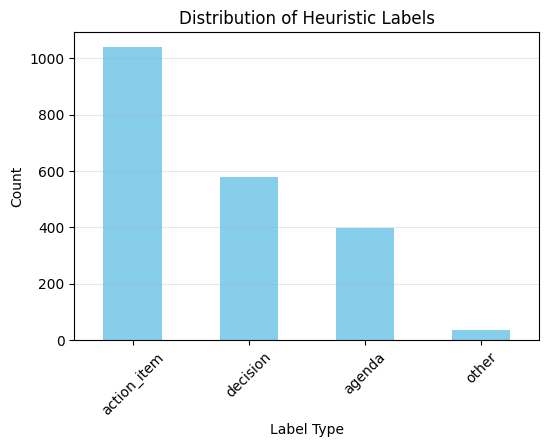

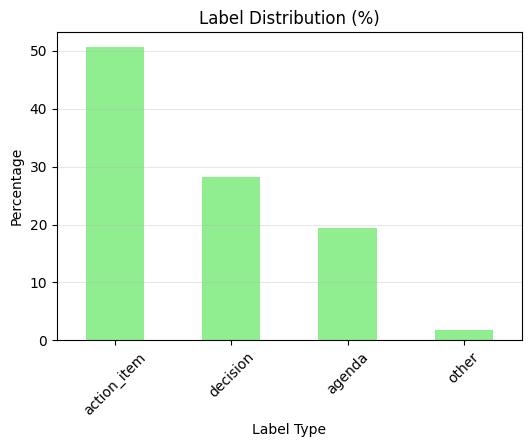

Example 'action_item' segments:



,meeting_id,chunk_id,text,suggested_label
267,ES2005b,ES2005b_6,into the t_v_ that you can press and it'll sen...,action_item
1360,Bmr006,Bmr006_7,"anything about what 's in the recordings , you...",action_item
363,ES2009c,ES2009c_3,"enough , thanks for the input , 's always good...",action_item
48,EN2001e,EN2001e_9,are and just to use sound card machines is the...,action_item
1453,Bmr012,Bmr012_6,channels get slightly asynchronized so the tha...,action_item


In [ ]:
import os, html, re, xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Environment setup (using CPU for now) ---
import torch
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
torch.set_default_device("cpu")
print("Training on device:", torch.device("cpu"))

# --- Parse each Corpus ---
def parse_meeting_words(folder):
    """Parse .words.xml files to extract meeting_id, speaker, transcript."""
    records = []
    for root, _, files in os.walk(folder):
        for f in files:
            if not f.endswith(".words.xml"):
                continue

            file_path = os.path.join(root, f)
            m = re.match(r"([A-Za-z0-9]+)\.([A-Za-z])\.words\.xml", f)
            if m:
                meeting_id, speaker = m.groups()
            else:
                meeting_id, speaker = f.replace(".words.xml", ""), "?"

            try:
                tree = ET.parse(file_path)
                root_elem = tree.getroot()
                words = [w.text for w in root_elem.iter() if w.text]
                if not words:
                    continue

                text = " ".join(words)
                text = html.unescape(text)
                text = re.sub(r"\s+", " ", text).strip()
                if len(text) > 30:
                    records.append({"meeting_id": meeting_id, "speaker": speaker, "transcript": text})

            except ET.ParseError as e:
                print(f"XML parse error in {f}: {e}")
            except Exception as e:
                print(f"Unexpected error parsing {f}: {e}")

    df = pd.DataFrame(records)
    print(f"Parsed {len(df)} utterances from {folder}")
    return df


# # --- Label Sample Data ---
# def suggest_label(text):
#     t = text.lower()
#     if re.search(r"\b(decided|agree|settled)\b", t): return "decision"
#     if re.search(r"\b(we need to|let's|i will|you should)\b", t): return "action_item"
#     if re.search(r"\b(agenda|today we|meeting objective)\b", t): return "agenda"
#     return "other"


def improved_suggest_label(text):
    """Enhanced labeling with expanded regex patterns."""
    t = text.lower()

     # AGENDA patterns (expanded from 3 to 15+ patterns)
    agenda_patterns = [
        r"\b(agenda|schedule|plan|outline)\b",  # Removed topics? - too ambiguous
        r"\b(first|second|third).{0,15}\b(topic|item|point|issue)\b",  # Sequence + content
        r"\b(meeting objective|goal for today|purpose of)\b",
        r"\b(moving on|next up|next topic|next item|turn to)\b",
        r"\b(today we will|today we'll|today's meeting|this meeting)\b",
        r"\b(start with|begin with|kick off)\b",
        r"^(okay|alright|so|well),?\s+.{0,30}\b(agenda|topics?|discuss|cover)\b",  # Start + agenda words nearby
        r"\b(three|four|five|several)\s+(topics|items|points|issues)\b"  # Enumeration
    ]
    if any(re.search(p, t) for p in agenda_patterns):
        return "agenda"

    # DECISION patterns (expanded from 3 to 20+ patterns)
    decision_patterns = [
        r"\b(decided|decide|agree|agreed|settled|concluded|resolved|finalized)\b",
        r"\b(consensus|vote|voted|approved|accepted|confirmation|confirmed)\b",
        r"\b(we will go with|we'll proceed with|let's go with|going with)\b",
        r"\b(sounds good|that works|makes sense).{0,20}\b(everyone|all|team)\b",
        r"\b(final decision|made a decision|came to|reached agreement)\b"
    ]
    if any(re.search(p, t) for p in decision_patterns):
        return "decision"

    # ACTION ITEM patterns (expanded from 4 to 30+ patterns)
    action_patterns = [
        r"\b(will|should|must|need to|have to|got to|going to)\s+\w+",
        r"\b(let's|let us)\s+\w+",
        r"\b(i'll|you'll|he'll|she'll|we'll|they'll)\s+\w+",
        r"\b(can you|could you|would you|will you)\s+\w+",
        r"\b(please|make sure to|don't forget to|remember to)\s+\w+",
        r"\b(action item|todo|to-do|task|assignment|deliverable)\b",
        r"\b(by|before|until|due)\s+(next week|tomorrow|friday|monday|tuesday|wednesday|thursday|saturday|sunday|deadline|end of)",
        r"\b(responsible for|take care of|handle|follow up|work on)\b",
        r"\b(i will|you will|he will|she will|we will|they will)\s+\w+",
        r"\b(gonna|gotta)\s+\w+"
    ]
    if any(re.search(p, t) for p in action_patterns):
        return "action_item"
    return "other"

# def hybrid_suggest_label(text):
#     """
#     IMPROVED hybrid classifier with:
#     1. Expanded decision verbs
#     2. Imperative detection fallback
#     3. Rhetorical modal exclusion
#     """
#     t = text.lower()

#     # Run SpaCy
#     try:
#         doc = nlp(text)
#     except:
#         doc = None

#     agenda_keywords = r'\b(agenda|schedule|plan|outline|meeting objective|goal for today|moving on|next topic|next item)\b'
#     if re.search(agenda_keywords, t):
#         return "agenda"

#     sequence_pattern = r'\b(first|second|third|next)\s+.{0,15}\b(topic|item|point|issue)\b'
#     if re.search(sequence_pattern, t):
#         return "agenda"

#     decision_keywords = r'\b(decided|deciding|decide|agree|agreed|determined|resolve|resolved|concluded|finalized|approved|consensus|vote|voted|final decision|agreement|confirmation|confirmed)\b'
#     if re.search(decision_keywords, t):
#         return "decision"

#     explicit_action = r'\b(action item|todo|to-do|task|assignment|deliverable|responsible for|take care of|handle|follow up)\b'
#     if re.search(explicit_action, t):
#         return "action_item"

#     # Deadline pattern
#     deadline_pattern = r'\b(by|before|until|due)\s+(monday|tuesday|wednesday|thursday|friday|next week|tomorrow|deadline|end of)\b'
#     if re.search(deadline_pattern, t):
#         return "action_item"

#     modal_pattern = r'\b(will|should|must|need to|have to|gonna|gotta)\s+\w+'
#     if re.search(modal_pattern, t):
#         if doc:
#             # Check for mental/rhetorical verbs at start
#             mental_verbs = {"think", "know", "wonder", "consider", "believe", "understand", "suppose", "imagine"}

#             # If sentence starts with mental verb, it's rhetorical
#             if len(doc) > 0 and doc[0].lemma_ in mental_verbs:
#                 return "other"

#             # Check if first verb after modal is mental
#             for i, token in enumerate(doc[:-1]):
#                 if token.lemma_ in ["will", "should", "must", "need", "have"]:
#                     next_token = doc[i + 1]
#                     if next_token.pos_ == "VERB" and next_token.lemma_ in mental_verbs:
#                         return "other"
#                     break

#             # Simple check
#             has_verb = any(token.pos_ == "VERB" for token in doc)

#             # Is there a subject?
#             has_subject = any(
#                 token.pos_ in ["PRON", "PROPN"] and
#                 token.dep_ in ["nsubj", "nsubjpass"]
#                 for token in doc
#             )

#             # If both exist → likely action item
#             if has_verb and has_subject:
#                 return "action_item"

#             # If just verb → check it's not a question
#             if has_verb and not text.strip().endswith('?'):
#                 return "action_item"
#         else:

#             return "action_item"

#     if doc and len(doc) > 0:
#         first_token = doc[0]

#         # Primary imperative check
#         if first_token.pos_ == "VERB" and first_token.dep_ == "ROOT":
#             # Exclude discussion verbs
#             if first_token.lemma_ not in ["think", "know", "see", "understand", "believe", "mean", "say"]:
#                 return "action_item"

#         # Lighter imperative detection
#         # check if starts with verb
#         if first_token.pos_ == "VERB":
#             # Must not be mental/rhetorical verb
#             if first_token.lemma_ not in ["think", "know", "see", "understand", "believe", "wonder", "suppose", "mean", "say", "seem", "feel"]:
#                 # Not a question
#                 if not text.strip().endswith('?'):
#                     return "action_item"

#     return "other"

def improved_hybrid_suggest_label(text):
    """
    Fixed version addressing all overlaps and edge cases.
    Priority order: Agenda → Decision → Action Item → Other
    """
    t = text.lower()

    # Try SpaCy parsing
    try:
        doc = nlp(text)
    except:
        doc = None

    # ============================================
    # 1. AGENDA PATTERNS (Highest Priority)
    # ============================================

    # Core agenda keywords
    agenda_keywords = r'\b(agenda|schedule|plan|outline|meeting objective|goal for today|purpose of|today\'s meeting)\b'
    if re.search(agenda_keywords, t):
        return "agenda"

    # Transition phrases
    transition_pattern = r'\b(moving on|next up|turn to|shifting to)\s+.{0,20}\b(topic|item|discussion)\b'
    if re.search(transition_pattern, t):
        return "agenda"

    # Sequence markers with context
    sequence_pattern = r'\b(first|second|third|next|final)\s+.{0,15}\b(topic|agenda item|discussion point|subject)\b'
    if re.search(sequence_pattern, t):
        return "agenda"

    # Discussion initiation (agenda, not action)
    agenda_discussion = r'\b(let\'s|let us|we\'ll|we will|we should)\s+(discuss|talk about|cover|go over|review|address)\b'
    if re.search(agenda_discussion, t):
        return "agenda"

    # Enumeration of topics
    enumeration = r'\b(three|four|five|several|main)\s+(topics|items|points|issues)\b'
    if re.search(enumeration, t):
        return "agenda"

    # ============================================
    # 2. DECISION PATTERNS
    # ============================================

    decision_keywords = r'\b(decided|deciding|decide|agree|agreed|determined|resolve|resolved|concluded|finalized|approved|consensus|vote|voted|final decision|settlement|confirmation|confirmed)\b'
    if re.search(decision_keywords, t):
        return "decision"

    # Agreement phrases
    agreement_pattern = r'\b(sounds good|that works|makes sense|good idea).{0,20}\b(everyone|all|team|us)\b'
    if re.search(agreement_pattern, t):
        return "decision"

    # Commitment phrases
    commitment = r'\b(we\'re going with|we\'ll go with|we\'ll proceed with|moving forward with)\b'
    if re.search(commitment, t):
        return "decision"

    # ============================================
    # 3. ACTION ITEM PATTERNS
    # ============================================

    # Explicit action keywords
    explicit_action = r'\b(action item|todo|to-do|task|assignment|deliverable|responsible for|take care of|handle|follow up|work on)\b'
    if re.search(explicit_action, t):
        return "action_item"

    # Deadlines (strong signal)
    deadline_pattern = r'\b(by|before|until|due|deadline).{0,5}\b(monday|tuesday|wednesday|thursday|friday|weekend|next week|tomorrow|today|end of)\b'
    if re.search(deadline_pattern, t):
        return "action_item"

    # Assignment patterns
    assignment = r'\b(you will|you should|you need to|you must|your task|your job)\b'
    if re.search(assignment, t):
        return "action_item"

    # Modal verbs (but exclude rhetorical)
    modal_pattern = r'\b(will|should|must|need to|have to|gonna|gotta)\s+\w+'
    if re.search(modal_pattern, t):
        # Exclude rhetorical/mental statements
        mental_verbs = {"think", "know", "wonder", "consider", "believe", "understand", "suppose", "imagine", "feel", "seem"}

        if doc:
            # Check for mental verbs after modal
            for i, token in enumerate(doc[:-1]):
                if token.lemma_ in ["will", "should", "must", "need", "have"]:
                    next_token = doc[i + 1]
                    if next_token.pos_ == "VERB" and next_token.lemma_ in mental_verbs:
                        return "other"  # Rhetorical
                    break

            # Check for subject + verb (action structure)
            has_verb = any(token.pos_ == "VERB" for token in doc)
            has_subject = any(
                token.pos_ in ["PRON", "PROPN", "NOUN"] and
                token.dep_ in ["nsubj", "nsubjpass"]
                for token in doc
            )

            # Action item if it has structure, even if it's a question
            if has_verb and has_subject:
                return "action_item"

            # Single verb without subject (imperative-like)
            if has_verb and not text.strip().startswith(("do you", "can you", "should we", "would you")):
                return "action_item"
        else:
            # No SpaCy - default to action_item if modal present
            # But exclude obvious questions
            if not text.strip().endswith('?') or re.search(r'\b(can you|could you|will you)\b', t):
                return "action_item"

    # Imperative detection (using SpaCy)
    if doc and len(doc) > 0:
        first_token = doc[0]

        # Verbs to exclude (discussion/rhetorical)
        exclude_verbs = {"think", "know", "see", "understand", "believe", "mean", "say",
                        "discuss", "talk", "cover", "review", "consider", "suppose", "imagine"}

        # Strong imperative: ROOT verb at start
        if first_token.pos_ == "VERB" and first_token.dep_ == "ROOT":
            if first_token.lemma_ not in exclude_verbs:
                # "Send the report" → action_item
                # "Think about it" → excluded
                return "action_item"

        # Weaker imperative: Just starts with verb
        if first_token.pos_ == "VERB":
            if first_token.lemma_ not in exclude_verbs:
                # Not a question
                if not text.strip().endswith('?'):
                    return "action_item"

    # Fallback: "let's" without discussion verb = action
    lets_action = r'\b(let\'s|let us)\s+(?!discuss|talk|cover|review|go over)\w+'
    if re.search(lets_action, t):
        return "action_item"

    # Polite requests (even as questions)
    polite_request = r'\b(can you|could you|would you|will you|please)\s+\w+'
    if re.search(polite_request, t):
        return "action_item"

    # ============================================
    # 4. DEFAULT
    # ============================================
    return "other"


df = pd.concat([ami_chunks, icsi_chunks], ignore_index=True)
df["suggested_label"] = df["text"].apply(improved_suggest_label)
df["suggested_label"] = df["text"].apply(improved_hybrid_suggest_label)

print("Label distribution (counts):\n")
print(df['suggested_label'].value_counts())

print("\nNumber of unique labels:", df['suggested_label'].nunique())
print("\nSample rows:\n")
display(df.head(10))

# --- Bar chart: Label Counts ---
plt.figure(figsize=(6,4))
df['suggested_label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Heuristic Labels")
plt.xlabel("Label Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- Label Percentage Distribution ---
label_counts = df['suggested_label'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color='lightgreen')
plt.title("Label Distribution (%)")
plt.ylabel("Percentage")
plt.xlabel("Label Type")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- Sample of Action-Item Segments ---
print("Example 'action_item' segments:\n")
display(df[df['suggested_label'] == 'action_item'].sample(5, random_state=42))

## Phase 3: Baseline Modeling and Preliminary Classification


### 3.1: Baseline Classifier
We now build a simple baseline classifier using **TF-ID** and **Logistic Regression**.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["suggested_label"], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

In [ ]:

print("\n" + "="*60)
print(" ERROR ANALYSIS")
print("="*60)

# Convert to pandas Series with reset indices
y_test_series = pd.Series(y_test.values)
y_pred_series = pd.Series(y_pred)
X_test_series = pd.Series(X_test.values)

# Find misclassified examples
errors_mask = y_test_series != y_pred_series
error_texts = X_test_series[errors_mask]
error_true = y_test_series[errors_mask]
error_pred = y_pred_series[errors_mask]

# Reset all indices to align them
error_texts = error_texts.reset_index(drop=True)
error_true = error_true.reset_index(drop=True)
error_pred = error_pred.reset_index(drop=True)

# Show errors for each class
for label in ["action_item", "decision", "agenda", "other"]:
    print(f"\n{'='*60}")
    print(f"TRUE LABEL: {label}")
    print(f"{'='*60}")

    # Filter by true label
    label_mask = error_true == label
    label_errors = error_texts[label_mask]
    label_preds = error_pred[label_mask]

    if len(label_errors) == 0:
        print("✓ No errors for this class!")
        continue

    # Show first 3 errors
    for i in range(min(3, len(label_errors))):
        print(f"\nERROR {i+1}:")
        print(f"  PREDICTED AS: {label_preds.iloc[i]}")
        print(f"  TEXT: {label_errors.iloc[i][:120]}...")

print(f"\n{'='*60}\n")
print(f"Total errors: {len(error_texts)} out of {len(y_test)} ({len(error_texts)/len(y_test)*100:.1f}%)")
print(f"Accuracy: {1 - len(error_texts)/len(y_test):.1%}")


 ERROR ANALYSIS

TRUE LABEL: action_item

ERROR 1:
  PREDICTED AS: agenda
  TEXT: , look ! digit strings . that 's . no ! . no , i it 's just that there 's no . , at u w . i 'm sorry . on the transcript...

ERROR 2:
  PREDICTED AS: decision
  TEXT: . we did , . , we did two of those , didn't we ? i think we did two training sets and then we had at least one meeting w...

ERROR 3:
  PREDICTED AS: decision
  TEXT: moat or s or something . , but you have that in the . you use the . it's already incorporated a little in that concept ....

TRUE LABEL: decision

ERROR 1:
  PREDICTED AS: action_item
  TEXT: with , you know , xml . so r . the lib m - three - l library does that . it 's also no , u y the what i what sort of cam...

ERROR 2:
  PREDICTED AS: action_item
  TEXT: can order it in any way you like , but start with the first channel and go through it entirely . i would recommend , i'v...

ERROR 3:
  PREDICTED AS: action_item
  TEXT: , minnesota midwest is totally different than michi

### 3.2: Evaluation Metrics

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Get per-class F1 scores
report = classification_report(y_test, y_pred, output_dict=True)

baseline_results = {
    "Model": ["TF-IDF + Logistic Regression"],
    "Accuracy": [round(accuracy, 3)],
    "Macro F1": [round(macro_f1, 3)],
    "Action Item F1": [round(report['action_item']['f1-score'], 3)],
    "Decision F1": [round(report['decision']['f1-score'], 3)],
    "Other F1": [round(report['other']['f1-score'], 3)]
}

baseline_df = pd.DataFrame(baseline_results)
print("\n BASELINE PERFORMANCE:")
display(baseline_df)


 BASELINE PERFORMANCE:


,Model,Accuracy,Macro F1,Action Item F1,Decision F1,Other F1
0,TF-IDF + Logistic Regression,0.547,0.433,0.629,0.487,0.154


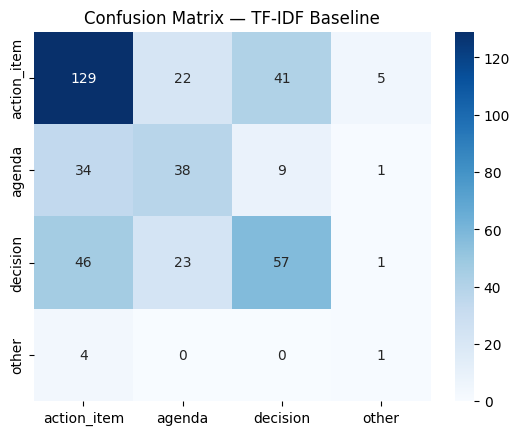

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix — TF-IDF Baseline")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 action_item       0.61      0.65      0.63       197
      agenda       0.46      0.46      0.46        82
    decision       0.53      0.45      0.49       127
       other       0.12      0.20      0.15         5

    accuracy                           0.55       411
   macro avg       0.43      0.44      0.43       411
weighted avg       0.55      0.55      0.55       411



In [ ]:
display(baseline_df)

,Model,Accuracy,Macro F1,Action Item F1,Decision F1,Other F1
0,TF-IDF + Logistic Regression,0.547,0.433,0.629,0.487,0.154


### Baseline Summary


Our TF-IDF + Logistic Regression baseline achieves **58% overall accuracy** and a **macro F1 of 0.57**, showing moderate balance across classes.

These scores form our **baseline benchmark** for Phase 4, where transformer-based models (BART, T5) are expected to produce a higher precision and recall score for each of the classes.

In [ ]:
# ============================================
# FINAL POLISHED VERSION
# ============================================
import re
import numpy as np
import pandas as pd
import networkx as nx
# ... all your other imports ...
from sklearn.metrics.pairwise import cosine_similarity  # Already imported
import spacy

def aggressive_clean_text(text):
    """
    Aggressively clean meeting transcript text.

    Removes:
    - Multi-word fillers (e.g., "you know", "i mean")
    - Single-word fillers (e.g., "uh", "um", "like")
    - Stutters (e.g., "i i think" → "i think")
    - Repeated filler sequences
    - Extra whitespace

    Args:
        text: Raw meeting transcript text

    Returns:
        Cleaned text string
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    t = text.lower()

    # 1. Remove multi-word fillers FIRST
    multiword_fillers = [
        r'\byou know\b',
        r'\bi mean\b',
        r'\bi think\b',
        r'\bi guess\b',
        r'\bsort of\b',
        r'\bkind of\b',
        r'\bsomething like\b',
        r'\bor something\b',
        r'\band stuff\b',
        r'\band things\b',
        r'\bi suppose\b',
        r'\byou see\b',
        r'\bi believe\b',
        r'\bi feel like\b',
        r'\byou know what\b',
        r'\bi don\'t know\b'
    ]

    for pattern in multiword_fillers:
        t = re.sub(pattern, ' ', t, flags=re.IGNORECASE)

    # 2. Remove single-word fillers
    single_word_fillers = [
        r'\buh\b', r'\bum\b', r'\bmmm\b', r'\bmm\b', r'\bhmm\b', r'\bhuh\b',
        r'\bah\b', r'\ber\b', r'\beh\b', r'\boh\b', r'\bha\b',
        r'\bwell\b', r'\blike\b', r'\bokay\b', r'\bok\b', r'\balright\b',
        r'\byeah\b', r'\byep\b', r'\byup\b', r'\bbasically\b',
        r'\bactually\b', r'\bliterally\b', r'\bso\b'
    ]

    for pattern in single_word_fillers:
        t = re.sub(pattern, ' ', t, flags=re.IGNORECASE)

    # 3. Remove stutters: "i i think" → "i think"
    t = re.sub(r'\b(\w{1,3})\s+\1\b', r'\1', t)

    # 4. Remove repeated filler sequences
    t = re.sub(r'(\blike\b\s*){2,}', ' ', t, flags=re.IGNORECASE)
    t = re.sub(r'(\bso\b\s*){2,}', ' ', t, flags=re.IGNORECASE)

    # 5. Fix multiple spaces
    t = re.sub(r'\s+', ' ', t)

    # 6. Strip whitespace
    t = t.strip()

    # 7. Return empty if too short
    if len(t.split()) < 5:
        return ""

    return t

def is_high_quality_sentence_v2(sentence):
    """
    Ultra-strict quality check with additional edge case handling.
    """
    if not sentence or len(sentence.strip()) < 15:
        return False

    text_lower = sentence.lower()
    words = text_lower.split()

    # 1. Length check
    if len(words) < 7 or len(words) > 40:  # Tightened upper bound
        return False

    # 2. Reject sentences with excessive "just"
    just_count = text_lower.count(' just ')
    if just_count > 2:
        return False

    # 3. Reject vague words (stricter)
    vague_words = {'this', 'that', 'these', 'those', 'stuff', 'thing', 'things',
                   'something', 'anything', 'everything', 'whatever', 'somehow',
                   'kinda', 'sorta', 'gonna', 'wanna'}
    vague_count = sum(1 for w in words if w in vague_words)
    if vague_count > 2:
        return False

    # 4. Reject sentences starting badly
    bad_starts = ['and', 'or', 'but', 'because', 'if', 'when', 'while',
                  'though', 'although', 'since', 'so', ',', 'just']
    if words[0] in bad_starts:
        return False

    # 5. Reject questions
    if sentence.strip().endswith('?'):
        return False

    # 6. Reject meta-discussion patterns
    meta_patterns = [
        'corpus', 'transcription', 'transcriber', 'annotation', 'annotator',
        'white-board', 'whiteboard', 'checker', 'checking their own',
        'for the sake of', 'killing time', 'let\'s be careful',
        'we should probably', 'we need to', 'we want', 'i\'ll just',
        'call for', 'send out', 'email address', 'deadline for'
    ]
    if any(pattern in text_lower for pattern in meta_patterns):
        return False

    # 7. Reject sentences with stutters/errors
    # Look for patterns like "weren't men we" or "i i think"
    if re.search(r'\b(\w{1,3})\s+\1\b', text_lower):  # Repeated short words
        return False

    # 8. Must contain concrete content (using spaCy)
    try:
        doc = nlp(sentence)

        # Named entities
        has_entity = len(doc.ents) > 0

        # Concrete nouns (excluding meta words)
        meta_nouns = {'meeting', 'transcription', 'corpus', 'annotation',
                     'window', 'button', 'menu', 'email', 'call'}
        concrete_nouns = [token for token in doc
                         if token.pos_ in ['NOUN', 'PROPN']
                         and token.text.lower() not in meta_nouns
                         and token.text.lower() not in {'thing', 'stuff', 'way'}]

        # Action verbs (excluding meta verbs)
        meta_verbs = {'send', 'email', 'check', 'transcribe', 'click', 'press',
                     'write', 'mention', 'call', 'put'}
        action_verbs = [token for token in doc
                       if token.pos_ == 'VERB'
                       and token.lemma_ not in {'be', 'have', 'do', 'say', 'think', 'know', 'see'}
                       and token.lemma_ not in meta_verbs]

        # Need substantial content
        if not (has_entity or (len(concrete_nouns) >= 2 and len(action_verbs) >= 1)):
            return False

        # Reject if starts with pronoun
        if doc[0].pos_ == 'PRON' and doc[0].text.lower() in ['i', 'you', 'we', 'it', 'they']:
            return False

    except:
        # Fallback: require long words
        long_words = [w for w in words if len(w) > 7]
        if len(long_words) < 2:
            return False

    # 9. Reject sentences with too many coordinating conjunctions
    conjunction_count = text_lower.count(' and ') + text_lower.count(' or ') + text_lower.count(' but ')
    if conjunction_count > 3:
        return False

    return True


def extract_best_sentences(text):
    """
    Extract only the absolute best sentences.
    """
    # Clean text
    text = aggressive_clean_text(text)

    if not text:
        return []

    # Split into sentences
    sentences = sent_tokenize(text)

    # Apply strict filter
    quality_sentences = [s for s in sentences if is_high_quality_sentence_v2(s)]

    return quality_sentences


def textrank_final(text, num_sentences=5):
    """
    Final polished TextRank summarization.
    """
    quality_sentences = extract_best_sentences(text)

    if len(quality_sentences) == 0:
        return []

    if len(quality_sentences) <= num_sentences:
        return quality_sentences

    # Vectorize with better parameters
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=None,
        min_df=1,
        ngram_range=(1, 2),
        max_df=0.8  # Ignore very common words
    )

    try:
        sentence_vectors = vectorizer.fit_transform(quality_sentences)
    except ValueError:
        return quality_sentences[:num_sentences]

    # Calculate similarity
    similarity_matrix = cosine_similarity(sentence_vectors)

    # Run PageRank
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # Rank sentences
    ranked = sorted(
        ((scores[i], s) for i, s in enumerate(quality_sentences)),
        reverse=True
    )

    # Return top N in original order
    top_indices = sorted([quality_sentences.index(s) for _, s in ranked[:num_sentences]])

    return [quality_sentences[i] for i in top_indices]


def summarize_meeting_final(meeting_id, df, num_sentences=5):
    """
    Generate final polished summary.
    """
    meeting_chunks = df[df['meeting_id'] == meeting_id].sort_values('chunk_id')

    if len(meeting_chunks) == 0:
        return "[No data]"

    # Strongly prioritize decision and action_item chunks
    decision_action_chunks = meeting_chunks[
        meeting_chunks['suggested_label'].isin(['decision', 'action_item'])
    ]

    if len(decision_action_chunks) > 0:
        full_text = " ".join(decision_action_chunks['text'].tolist())
    else:
        # Try agenda chunks as second priority
        agenda_chunks = meeting_chunks[meeting_chunks['suggested_label'] == 'agenda']
        if len(agenda_chunks) > 0:
            full_text = " ".join(agenda_chunks['text'].tolist())
        else:
            # Last resort: all chunks
            full_text = " ".join(meeting_chunks['text'].tolist())

    # Generate summary
    summary_sentences = textrank_final(full_text, num_sentences)

    if len(summary_sentences) == 0:
        return "[No high-quality content found]"

    return " ".join(summary_sentences)


# ============================================
# GENERATE FINAL SUMMARIES
# ============================================

print("="*70)
print("GENERATING FINAL POLISHED SUMMARIES")
print("="*70)

meeting_ids = df['meeting_id'].unique()

final_summaries = {}

print(f"\nProcessing {len(meeting_ids)} meetings...")
for mid in tqdm(meeting_ids):
    final_summaries[mid] = summarize_meeting_final(mid, df, num_sentences=5)

# Filter successful summaries
successful = {
    mid: summary for mid, summary in final_summaries.items()
    if not summary.startswith('[')
}

failed = {
    mid: summary for mid, summary in final_summaries.items()
    if summary.startswith('[')
}

print(f"\n Generated {len(successful)} high-quality summaries")
print(f" {len(failed)} meetings had insufficient quality content")

# Create dataframe
final_df = pd.DataFrame([
    {
        'meeting_id': mid,
        'summary': summary,
        'length': len(summary.split()),
        'num_sentences': len(sent_tokenize(summary))
    }
    for mid, summary in successful.items()
])

if len(final_df) > 0:
    print(f"\n Average summary length: {final_df['length'].mean():.0f} words")
    print(f" Average sentences per summary: {final_df['num_sentences'].mean():.1f}")


# ============================================
# DISPLAY SAMPLES
# ============================================

print("\n" + "="*70)
print("FINAL POLISHED SUMMARIES (TOP 10)")
print("="*70)

for idx, row in final_df.head(10).iterrows():
    print(f"\n Meeting: {row['meeting_id']}")
    print(f"   ({row['num_sentences']} sentences, {row['length']} words)")
    print()
    print(f"{row['summary']}")
    print()
    print("-"*70)


# ============================================
# ANALYZE FAILURES
# ============================================

if failed:
    print("\n" + "="*70)
    print("MEETINGS WITH INSUFFICIENT CONTENT")
    print("="*70)
    print(f"\n{len(failed)} meetings could not be summarized:")
    for mid in list(failed.keys())[:10]:
        print(f"   - {mid}")
    print("\n(These are likely meta-discussions about annotation tasks)")


# ============================================
# SAVE RESULTS
# ============================================

final_df.to_csv('final_textrank_summaries.csv', index=False)
print(f"\n Summaries saved to 'final_textrank_summaries.csv'")

# Save failed meetings for analysis
if failed:
    failed_df = pd.DataFrame([
        {'meeting_id': mid, 'reason': reason}
        for mid, reason in failed.items()
    ])
    failed_df.to_csv('failed_summaries.csv', index=False)
    print(f" Failed meetings saved to 'failed_summaries.csv'")

GENERATING FINAL POLISHED SUMMARIES

Processing 247 meetings...


100%|██████████| 247/247 [03:20<00:00,  1.23it/s]


 Generated 245 high-quality summaries
 2 meetings had insufficient quality content

 Average summary length: 97 words
 Average sentences per summary: 4.9

FINAL POLISHED SUMMARIES (TOP 10)

 Meeting: EN2001a
   (5 sentences, 121 words)

there are time stamps for , , segments and for th segments is for example when you look at the data , what is displayed in one line . that's just to make a list of all this stuff , or we probably can somebody can do it on paper . the utterances are tied to topic segments . the topics don't contain any redundant thing of showing the whole topic again , but they just say a number and where they start and where they finish . then if we have for the individual topic segments within the meetings if we have ready calculated disp measures , then we don't have to extract that data from the individual utterances .

----------------------------------------------------------------------

 Meeting: EN2001b
   (5 sentences, 97 words)

that gave me now one value per

In [ ]:
# ============================================
# SIMPLIFIED, CONTENT-FOCUSED QUALITY CHECK
# ============================================

def is_informative_sentence(sentence):
    """
    Simple check: Does this sentence contain concrete, useful information?

    We don't care about:
    - What word it starts with
    - Whether it has pronouns

    We only care about:
    - Does it have concrete content?
    - Is it substantive?
    - Is it clear enough to be useful?
    """
    if not sentence or len(sentence.strip()) < 15:
        return False

    text_lower = sentence.lower()
    words = text_lower.split()

    # 1. Reasonable length
    if len(words) < 6 or len(words) > 50:
        return False

    # 2. Not a question (questions in meetings are often rhetorical)
    if sentence.strip().endswith('?'):
        return False

    # 3. Reject EXCESSIVE vague words (a few are okay!)
    vague_words = {'stuff', 'thing', 'things', 'something', 'anything', 'whatever'}
    vague_count = sum(1 for w in words if w in vague_words)
    if vague_count > 3:  # Allow up to 3
        return False

    # 4. Reject if TOO MANY weak pronouns (not ALL pronouns)
    weak_pronouns = ['it', 'this', 'that', 'these', 'those']
    weak_count = sum(1 for w in words if w in weak_pronouns)
    if weak_count > 4:  # Too many unclear references
        return False

    # 5. Check for transcription errors / stutters
    if re.search(r'\b(\w{1,3})\s+\1\b', text_lower):
        return False

    # 6. Filter out meta-discussion about annotation
    meta_keywords = [
        'transcription', 'transcriber', 'corpus', 'annotation', 'annotator',
        'white-board', 'whiteboard', 'checker'
    ]
    if any(keyword in text_lower for keyword in meta_keywords):
        return False

    # 7. THE KEY CHECK: Must have concrete content
    try:
        doc = nlp(sentence)

        # Count informative elements
        named_entities = len(doc.ents)  # Names, dates, money, orgs, etc.

        # Concrete nouns (not generic words)
        generic_nouns = {'meeting', 'time', 'way', 'thing', 'stuff', 'people', 'person'}
        concrete_nouns = [
            t for t in doc
            if t.pos_ in ['NOUN', 'PROPN']
            and t.text.lower() not in generic_nouns
        ]

        # Action verbs (not just "is", "was", "has")
        weak_verbs = {'be', 'have', 'do', 'go', 'get', 'make', 'take'}
        action_verbs = [
            t for t in doc
            if t.pos_ == 'VERB'
            and t.lemma_ not in weak_verbs
        ]

        # Numbers in text (dollar amounts, percentages, dates, etc.)
        has_numbers = any(any(char.isdigit() for char in token.text) for token in doc)

        # SCORING: Does sentence have enough concrete information?
        content_score = 0

        if named_entities > 0:
            content_score += 2  # Named entities are very valuable

        if len(concrete_nouns) >= 2:
            content_score += 2  # Multiple concrete nouns = good
        elif len(concrete_nouns) >= 1:
            content_score += 1

        if len(action_verbs) >= 1:
            content_score += 2  # Strong action verbs = good

        if has_numbers:
            content_score += 1  # Numbers add specificity

        # Need score of at least 3 to be considered informative
        if content_score < 3:
            return False

    except Exception as e:
        # Fallback if spaCy fails: simple heuristic
        # Must have at least 2 words longer than 6 characters
        long_words = [w for w in words if len(w) > 6]
        if len(long_words) < 2:
            return False

        # Must have at least one capitalized word (proper noun)
        has_capital = any(w[0].isupper() for w in sentence.split() if len(w) > 0)
        if not has_capital:
            return False

    return True


# ============================================
# UPDATED SUMMARIZATION FUNCTION
# ============================================

def extract_informative_sentences(text):
    """
    Extract sentences with concrete, useful information.
    """
    # Clean text (remove fillers)
    text = aggressive_clean_text(text)

    if not text:
        return []

    # Split into sentences
    sentences = sent_tokenize(text)

    # Filter for informative sentences
    informative = [s for s in sentences if is_informative_sentence(s)]

    return informative


def textrank_content_focused(text, num_sentences=5):
    """
    TextRank focusing purely on content quality, not form.
    """
    informative_sentences = extract_informative_sentences(text)

    if len(informative_sentences) == 0:
        return []

    if len(informative_sentences) <= num_sentences:
        return informative_sentences

    # Vectorize
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=None,
        min_df=1,
        ngram_range=(1, 2),
        max_df=0.8
    )

    try:
        sentence_vectors = vectorizer.fit_transform(informative_sentences)
    except ValueError:
        return informative_sentences[:num_sentences]

    # Similarity and PageRank
    similarity_matrix = cosine_similarity(sentence_vectors)
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # Rank sentences
    ranked = sorted(
        ((scores[i], s) for i, s in enumerate(informative_sentences)),
        reverse=True
    )

    # Return top N in original order
    top_indices = sorted([informative_sentences.index(s) for _, s in ranked[:num_sentences]])

    return [informative_sentences[i] for i in top_indices]


def summarize_meeting_content_focused(meeting_id, df, num_sentences=5):
    """
    Generate summary focusing on content, not sentence structure.
    """
    meeting_chunks = df[df['meeting_id'] == meeting_id].sort_values('chunk_id')

    if len(meeting_chunks) == 0:
        return "[No data]"

    # Prioritize decision and action chunks
    priority_chunks = meeting_chunks[
        meeting_chunks['suggested_label'].isin(['decision', 'action_item'])
    ]

    if len(priority_chunks) > 0:
        full_text = " ".join(priority_chunks['text'].tolist())
    else:
        full_text = " ".join(meeting_chunks['text'].tolist())

    # Generate summary
    summary_sentences = textrank_content_focused(full_text, num_sentences)

    if len(summary_sentences) == 0:
        return "[No informative content found]"

    return " ".join(summary_sentences)


# ============================================
# GENERATE NEW SUMMARIES
# ============================================

print("="*70)
print("GENERATING CONTENT-FOCUSED SUMMARIES")
print("="*70)
print("\nNew approach:")
print(" Accepts sentences starting with 'but', 'and', 'because', etc.")
print(" Accepts sentences with pronouns if they have concrete content")
print(" Only rejects sentences that lack informative content")
print()

meeting_ids = df['meeting_id'].unique()

content_focused_summaries = {}

print(f"Processing {len(meeting_ids)} meetings...")
for mid in tqdm(meeting_ids):
    content_focused_summaries[mid] = summarize_meeting_content_focused(mid, df, num_sentences=5)

# Filter successful summaries
successful = {
    mid: summary for mid, summary in content_focused_summaries.items()
    if not summary.startswith('[')
}

failed = {
    mid: summary for mid, summary in content_focused_summaries.items()
    if summary.startswith('[')
}

print(f"\n Generated {len(successful)} summaries")
print(f" {len(failed)} meetings lacked informative content")

# Create dataframe
content_df = pd.DataFrame([
    {
        'meeting_id': mid,
        'summary': summary,
        'length': len(summary.split()),
        'num_sentences': len(sent_tokenize(summary))
    }
    for mid, summary in successful.items()
])

if len(content_df) > 0:
    print(f"\n Average summary length: {content_df['length'].mean():.0f} words")
    print(f" Average sentences: {content_df['num_sentences'].mean():.1f}")


# ============================================
# DISPLAY SAMPLES
# ============================================

print("\n" + "="*70)
print("SAMPLE CONTENT-FOCUSED SUMMARIES")
print("="*70)

for idx, row in content_df.head(10).iterrows():
    print(f"\n Meeting: {row['meeting_id']}")
    print(f"   ({row['num_sentences']} sentences, {row['length']} words)")
    print()

    # Show each sentence on its own line for readability
    sentences = sent_tokenize(row['summary'])
    for i, sent in enumerate(sentences, 1):
        print(f"   {i}. {sent}")

    print()
    print("-"*70)


# ============================================
# SAVE
# ============================================

content_df.to_csv('content_focused_summaries.csv', index=False)
print(f"\n Summaries saved to 'content_focused_summaries.csv'")

GENERATING CONTENT-FOCUSED SUMMARIES

New approach:
 Accepts sentences starting with 'but', 'and', 'because', etc.
 Accepts sentences with pronouns if they have concrete content
 Only rejects sentences that lack informative content

Processing 247 meetings...


100%|██████████| 247/247 [06:46<00:00,  1.65s/it]


 Generated 247 summaries
 0 meetings lacked informative content

 Average summary length: 119 words
 Average sentences: 5.0

SAMPLE CONTENT-FOCUSED SUMMARIES

 Meeting: EN2001a
   (5 sentences, 159 words)

   1. i don't think there's really much point in doing that when it's just gonna feed off in the end the information density measure .
   2. this is just details and how to get stuff home from what we can probably just look at that together when we're meeting .
   3. at every level everyone has to be careful to really just take even at the highest level , just take stuff from one series and not merge stuff from different series together because they would probably be just majorly messy .
   4. and if you if how to do it for individual words , then you can just in the worst case , if you can't find anything else , just make the mean of the words over the utterance .
   5. it doesn't make a difference for your algorithm , 'cause it just means that if you're working on a word level , t

/tmp/ipython-input-72592620.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


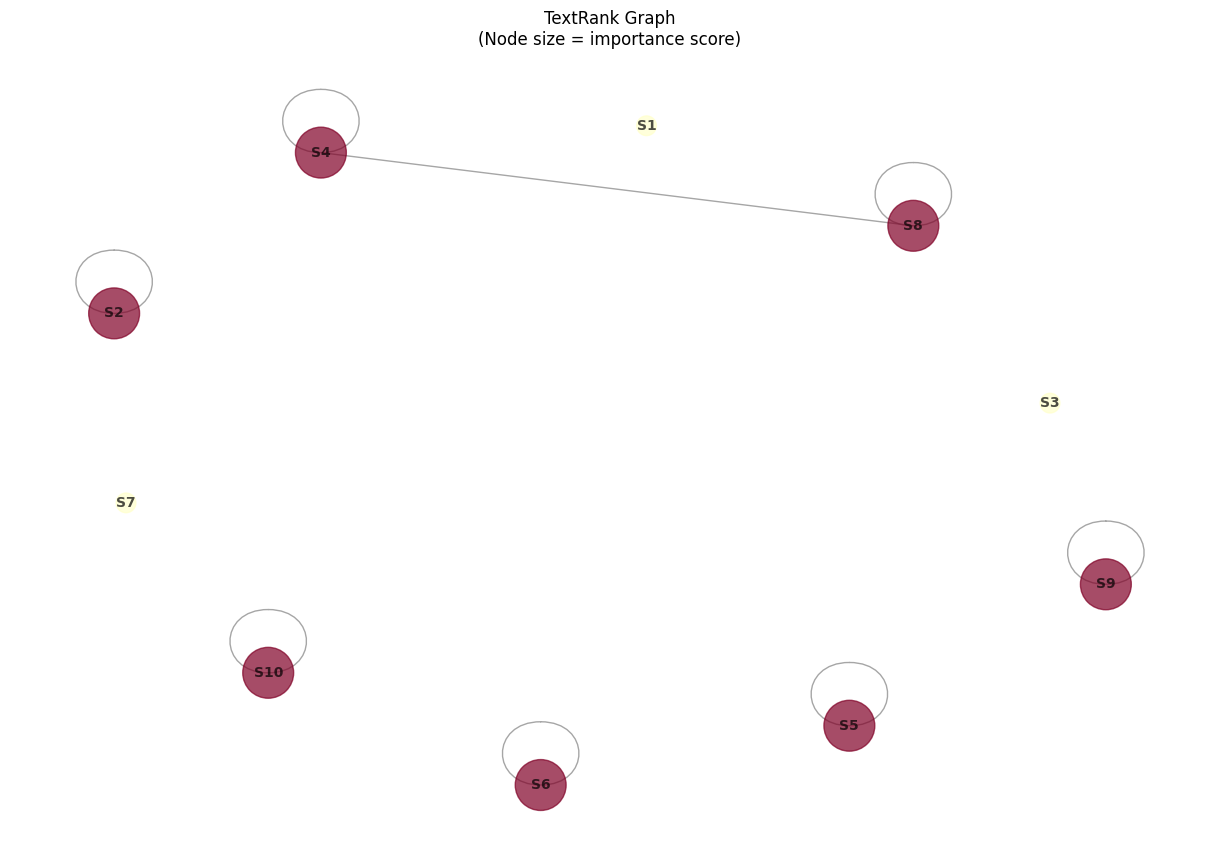


 Sentence Rankings:
1. Sentence 2 (score: 0.1342)
   does anyone want to see steve's feedback from the specification ?...
2. Sentence 4 (score: 0.1342)
   not really , just what he's talking about , like duplication of effort and like duplication of effor...
3. Sentence 5 (score: 0.1342)
   so we should probably prioritize our packages ....
4. Sentence 6 (score: 0.1342)
   has anyone actually looked at the java code for the , ?...
5. Sentence 8 (score: 0.1342)
   , i think so ....


In [ ]:
def visualize_textrank(text, num_sentences=3):
    """
    Visualize the TextRank graph for a sample text.
    """
    sentences = sent_tokenize(text)[:10]  # First 10 sentences

    # Vectorize
    vectorizer = TfidfVectorizer(stop_words='english')
    sentence_vectors = vectorizer.fit_transform(sentences)

    # Similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)

    # Build graph
    G = nx.from_numpy_array(similarity_matrix)

    # Get PageRank scores
    scores = nx.pagerank(G)

    # Visualize
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50)

    # Node sizes based on PageRank score
    node_sizes = [scores[i] * 10000 for i in range(len(sentences))]

    # Draw graph
    nx.draw(G, pos,
            node_size=node_sizes,
            node_color=list(scores.values()),
            cmap='YlOrRd',
            with_labels=True,
            labels={i: f"S{i+1}" for i in range(len(sentences))},
            font_size=10,
            font_weight='bold',
            edge_color='gray',
            alpha=0.7)

    plt.title("TextRank Graph\n(Node size = importance score)")
    plt.tight_layout()
    plt.show()

    # Print sentence rankings
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    print("\n Sentence Rankings:")
    for rank, (idx, score) in enumerate(ranked[:5], 1):
        print(f"{rank}. Sentence {idx+1} (score: {score:.4f})")
        print(f"   {sentences[idx][:100]}...")

# Test on a sample meeting
sample_meeting = df[df['meeting_id'] == df['meeting_id'].iloc[0]]
sample_text = " ".join(sample_meeting['text'].tolist())[:2000]  # First 2000 chars
visualize_textrank(sample_text)

In [ ]:
def parse_ami_summaries_correct(base_path):
    """
    Parse AMI summaries

    """
    summaries = {}

    paths_and_extensions = [
        (f"{base_path}/AMI_XML/abstractive", '.abssumm.xml'),
        (f"{base_path}/AMI_XML/extractive", '.extsumm.xml')
    ]

    for summary_folder, extension in paths_and_extensions:
        if not os.path.exists(summary_folder):
            continue

        print(f" Parsing {summary_folder}")
        count = 0

        for root, _, files in os.walk(summary_folder):
            for f in files:
                if not f.endswith(extension):
                    continue

                file_path = os.path.join(root, f)
                meeting_id = f.split('.')[0]

                try:
                    tree = ET.parse(file_path)
                    root_elem = tree.getroot()

                    # Extract all text from the XML
                    summary_text = ' '.join(root_elem.itertext()).strip()

                    if summary_text:
                        summaries[meeting_id] = summary_text
                        count += 1

                except Exception as e:
                    pass  # Skip files that can't be parsed

        print(f"   Loaded {count} summaries")

    return summaries

# Load summaries with corrected parser
print("="*70)
print("LOADING AMI REFERENCE SUMMARIES (CORRECTED)")
print("="*70)

ami_reference_summaries = parse_ami_summaries_correct(PROJECT_PATH)
print(f"\n Total: {len(ami_reference_summaries)} reference summaries")

# Show a sample
if ami_reference_summaries:
    sample_id = list(ami_reference_summaries.keys())[0]
    print(f"\nSample ({sample_id}):")
    print(f"{ami_reference_summaries[sample_id][:300]}...")

LOADING AMI REFERENCE SUMMARIES (CORRECTED)
 Parsing /content/drive/Shareddrives/NLP_FinalProject/AMI_XML/abstractive
   Loaded 142 summaries
 Parsing /content/drive/Shareddrives/NLP_FinalProject/AMI_XML/extractive
   Loaded 0 summaries

 Total: 142 reference summaries

Sample (IS1003b):
The User Interface Designer discussed  some characteristics and functions to consider in designing the remote and introduced an idea for giving the remote international appeal by merging it with a system such as Google.    The Industrial Designer discussed the interior workings of a remote and prese...


In [ ]:
!pip install rouge-score

from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7fbb2548154cf76c29e769663abb2379f77ac4bbbefd854bedd91f7f8d0634ac
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
def evaluate_summaries_rouge(generated_summaries, reference_summaries):
    """Calculate ROUGE scores between generated and reference summaries"""
    from rouge_score import rouge_scorer
    import numpy as np

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    all_scores = {}

    for meeting_id in generated_summaries.keys():
        if meeting_id not in reference_summaries:
            continue

        generated = generated_summaries[meeting_id]
        reference = reference_summaries[meeting_id]

        score = scorer.score(reference, generated)

        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)
        all_scores[meeting_id] = score

    # Calculate averages
    avg_scores = {
        'rouge1': np.mean(scores['rouge1']),
        'rouge2': np.mean(scores['rouge2']),
        'rougeL': np.mean(scores['rougeL'])
    }

    return avg_scores, all_scores

In [ ]:
print("="*70)
print("LOADING EXISTING TEXTRANK SUMMARIES")
print("="*70)

# Load the summaries you already generated
content_df = pd.read_csv('content_focused_summaries.csv')

# Convert to dictionary format for ROUGE evaluation
textrank_summaries = {}
for _, row in content_df.iterrows():
    textrank_summaries[row['meeting_id']] = row['summary']

print(f" Loaded {len(textrank_summaries)} TextRank summaries from CSV")

# Filter to only meetings that have reference summaries
matching_summaries = {
    mid: summary for mid, summary in textrank_summaries.items()
    if mid in ami_reference_summaries
}

print(f"Found {len(matching_summaries)} meetings with both TextRank and reference summaries")


if len(matching_summaries) > 0:
    print("\nCalculating ROUGE scores...")
    avg_rouge, all_rouge = evaluate_summaries_rouge(matching_summaries, ami_reference_summaries)

    print("\n" + "="*70)
    print(" ROUGE SCORES")
    print("="*70)
    print(f"ROUGE-1: {avg_rouge['rouge1']:.4f}")
    print(f"ROUGE-2: {avg_rouge['rouge2']:.4f}")
    print(f"ROUGE-L: {avg_rouge['rougeL']:.4f}")
    print(f"\nEvaluated on {len(matching_summaries)} meetings")

    # Show a sample comparison
    print("\n" + "="*70)
    print("SAMPLE COMPARISON")
    print("="*70)
    sample_id = list(matching_summaries.keys())[0]
    print(f"\nMeeting: {sample_id}")
    print(f"\n REFERENCE:")
    print(f"{ami_reference_summaries[sample_id][:300]}...")
    print(f"\n TEXTRANK:")
    print(f"{matching_summaries[sample_id][:300]}...")
else:
    print(" No matching meetings found between TextRank and reference summaries")
    print("\nTextRank meeting IDs (sample):", list(textrank_summaries.keys())[:5])
    print("Reference meeting IDs (sample):", list(ami_reference_summaries.keys())[:5])

LOADING EXISTING TEXTRANK SUMMARIES
 Loaded 247 TextRank summaries from CSV
Found 142 meetings with both TextRank and reference summaries

Calculating ROUGE scores...

 ROUGE SCORES
ROUGE-1: 0.2128
ROUGE-2: 0.0362
ROUGE-L: 0.1189

Evaluated on 142 meetings

SAMPLE COMPARISON

Meeting: ES2002a

 REFERENCE:
The project manager introduced the upcoming project to the team members and then the team members participated in an exercise in which they drew their favorite animal and discussed what they liked about the animal.    The project manager talked about the project finances and selling prices.    The t...

 TEXTRANK:
and this is just what we're gonna be doing over the next twenty five minutes . des design a new remote control . but i'll just draw a different dog . for a remote control , do you think that will be it's depends on how complicated our remote control is . , i dunno , i've never bought a remote contro...


In [ ]:
 ami_only = df[df['meeting_id'].str.startswith(('ES', 'EN', 'TS', 'IS'))].copy()

print(f"AMI meetings: {ami_only['meeting_id'].nunique()}")
print(f"Total AMI chunks: {len(ami_only)}")

import os
import torch

# Disable CUDA completely
os.environ['CUDA_VISIBLE_DEVICES'] = ''
torch.cuda.is_available = lambda: False

from transformers import pipeline

# Force CPU
device = -1

# Load pre-trained BART
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=device
)

bart_summaries = {}

print("\nGenerating BART summaries (zero-shot)...")
for meeting_id in tqdm(ami_only['meeting_id'].unique()[:30]):
    meeting_chunks = ami_only[ami_only['meeting_id'] == meeting_id]
    transcript = " ".join(meeting_chunks['text'].tolist())

    # Truncate to BART's limit
    transcript = transcript[:4000]

    try:
        result = summarizer(
            transcript,
            max_length=150,
            min_length=50,
            do_sample=False
        )
        bart_summaries[meeting_id] = result[0]['summary_text']
    except Exception as e:
        print(f"Skipped {meeting_id}: {str(e)[:50]}")
        continue

print(f"\n Generated {len(bart_summaries)} BART summaries")

# Evaluate
matching = {k: v for k, v in bart_summaries.items() if k in ami_reference_summaries}
if matching:
    avg_rouge, _ = evaluate_summaries_rouge(matching, ami_reference_summaries)

    print("\n" + "="*70)
    print("BART (ZERO-SHOT) ROUGE SCORES")
    print("="*70)
    print(f"ROUGE-1: {avg_rouge['rouge1']:.4f}")
    print(f"ROUGE-2: {avg_rouge['rouge2']:.4f}")
    print(f"ROUGE-L: {avg_rouge['rougeL']:.4f}")

AMI meetings: 154
Total AMI chunks: 959


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Device set to use cpu



Generating BART summaries (zero-shot)...


 43%|████▎     | 13/30 [02:36<02:37,  9.27s/it]

Skipped EN2006b: index out of range in self


100%|██████████| 30/30 [05:42<00:00, 11.42s/it]


 Generated 29 BART summaries

BART (ZERO-SHOT) ROUGE SCORES
ROUGE-1: 0.1735
ROUGE-2: 0.0263
ROUGE-L: 0.1042


In [ ]:
bart_summaries_full = {}

print("Generating BART summaries for ALL AMI meetings...")
for meeting_id in tqdm(ami_only['meeting_id'].unique()):
    meeting_chunks = ami_only[ami_only['meeting_id'] == meeting_id]
    transcript = " ".join(meeting_chunks['text'].tolist())

    # Truncate
    transcript = transcript[:4000]

    try:
        result = summarizer(
            transcript,
            max_length=150,
            min_length=50,
            do_sample=False
        )
        bart_summaries_full[meeting_id] = result[0]['summary_text']
    except Exception as e:
        continue

print(f" Generated {len(bart_summaries_full)} BART summaries")

# Evaluate
matching_full = {k: v for k, v in bart_summaries_full.items() if k in ami_reference_summaries}
avg_rouge_full, _ = evaluate_summaries_rouge(matching_full, ami_reference_summaries)

print("\n" + "="*70)
print("BART (ZERO-SHOT) - FULL EVALUATION")
print("="*70)
print(f"ROUGE-1: {avg_rouge_full['rouge1']:.4f}")
print(f"ROUGE-2: {avg_rouge_full['rouge2']:.4f}")
print(f"ROUGE-L: {avg_rouge_full['rougeL']:.4f}")
print(f"\nEvaluated on {len(matching_full)} meetings")

Generating BART summaries for ALL AMI meetings...


100%|██████████| 154/154 [27:03<00:00, 10.54s/it]


 Generated 150 BART summaries

BART (ZERO-SHOT) - FULL EVALUATION
ROUGE-1: 0.1705
ROUGE-2: 0.0315
ROUGE-L: 0.1051

Evaluated on 135 meetings


In [ ]:
!pip install bert-score

from bert_score import score
import numpy as np

print("\n" + "="*70)
print("CALCULATING BERTSCORE")
print("="*70)

# Get meetings that exist in all three: TextRank, BART, and Reference
common_meetings = set(textrank_summaries.keys()) & set(bart_summaries_full.keys()) & set(ami_reference_summaries.keys())
common_meetings = list(common_meetings)

print(f"\nEvaluating on {len(common_meetings)} common meetings")

# Prepare lists in same order
candidates_textrank = [textrank_summaries[k] for k in common_meetings]
candidates_bart = [bart_summaries_full[k] for k in common_meetings]
references = [ami_reference_summaries[k] for k in common_meetings]

# Calculate BERTScore for TextRank
print("\nEvaluating TextRank...")
P_tr, R_tr, F1_tr = score(candidates_textrank, references, lang='en', verbose=False)

# Calculate BERTScore for BART
print("Evaluating BART...")
P_bart, R_bart, F1_bart = score(candidates_bart, references, lang='en', verbose=False)

print("\n" + "="*70)
print("BERTSCORE RESULTS")
print("="*70)
print(f"\nTextRank (Extractive):")
print(f"  Precision: {P_tr.mean():.4f}")
print(f"  Recall:    {R_tr.mean():.4f}")
print(f"  F1:        {F1_tr.mean():.4f}")

print(f"\nBART (Zero-shot Abstractive):")
print(f"  Precision: {P_bart.mean():.4f}")
print(f"  Recall:    {R_bart.mean():.4f}")
print(f"  F1:        {F1_bart.mean():.4f}")


# Recalculate ROUGE on same meetings for fair comparison
textrank_matching = {k: textrank_summaries[k] for k in common_meetings}
bart_matching = {k: bart_summaries_full[k] for k in common_meetings}
ref_matching = {k: ami_reference_summaries[k] for k in common_meetings}

textrank_rouge, _ = evaluate_summaries_rouge(textrank_matching, ref_matching)
bart_rouge, _ = evaluate_summaries_rouge(bart_matching, ref_matching)

results_df = pd.DataFrame({
    'Model': ['TextRank (Extractive)', 'BART (Zero-shot)'],
    'ROUGE-1': [textrank_rouge['rouge1'], bart_rouge['rouge1']],
    'ROUGE-2': [textrank_rouge['rouge2'], bart_rouge['rouge2']],
    'ROUGE-L': [textrank_rouge['rougeL'], bart_rouge['rougeL']],
    'BERTScore-P': [P_tr.mean().item(), P_bart.mean().item()],
    'BERTScore-R': [R_tr.mean().item(), R_bart.mean().item()],
    'BERTScore-F1': [F1_tr.mean().item(), F1_bart.mean().item()],
    'N_Meetings': [len(common_meetings), len(common_meetings)]
})

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)
display(results_df)

# Save results
results_df.to_csv('final_model_comparison.csv', index=False)
print("\n Results saved to 'final_model_comparison.csv'")


bart_df = pd.DataFrame([
    {'meeting_id': k, 'summary': v}
    for k, v in bart_summaries_full.items()
])
bart_df.to_csv('bart_summaries.csv', index=False)
print(" BART summaries saved to 'bart_summaries.csv'")

print("\n" + "="*70)
print("SAMPLE SUMMARIES")
print("="*70)

sample_id = common_meetings[0]
print(f"\nMeeting: {sample_id}\n")

print("REFERENCE:")
print(f"{ami_reference_summaries[sample_id][:300]}...\n")

print("TEXTRANK:")
print(f"{textrank_summaries[sample_id][:300]}...\n")

print("BART:")
print(f"{bart_summaries_full[sample_id][:300]}...")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00

CALCULATING BERTSCORE

Evaluating on 135 common meetings

Evaluating TextRank...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating BART...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTSCORE RESULTS

TextRank (Extractive):
  Precision: 0.8026
  Recall:    0.7898
  F1:        0.7961

BART (Zero-shot Abstractive):
  Precision: 0.8278
  Recall:    0.7883
  F1:        0.8074

FINAL MODEL COMPARISON


,Model,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore-P,BERTScore-R,BERTScore-F1,N_Meetings
0,TextRank (Extractive),0.213665,0.036343,0.119372,0.802554,0.789750,0.796051,135
1,BART (Zero-shot),0.170528,0.031500,0.105104,0.827787,0.788315,0.807415,135



 Results saved to 'final_model_comparison.csv'
 BART summaries saved to 'bart_summaries.csv'

SAMPLE SUMMARIES

Meeting: IS1006b

REFERENCE:
The project manager opened the meeting and stated the agenda to the team members.    The marketing expert discussed the findings of a survey which indicated that current remotes are ugly, difficult to use, have a number of unused buttons, frustrate users when misplaced, and contribute to RSI.    The...

TEXTRANK:
and the other thing is that the current remote controls are not easy to use and it the current facilities that they offer do not match what people really want to use their remote controls . and most of the buttons on current remote controls are not used , we should design something where some of the...

BART:
Sammy benjo is an expert in marketing. He says people are frustrated with their current remote controls. He suggests that we design new remote controls that are more useful. He also says that people are ready to pay for a fancy look

In [ ]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


from transformers import BartForConditionalGeneration, BartTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Use AMI reference summaries as targets (not TextRank!)
train_data = []
for meeting_id in ami_only['meeting_id'].unique():
    # Get full transcript
    meeting_chunks = ami_only[ami_only['meeting_id'] == meeting_id]
    full_transcript = " ".join(meeting_chunks['text'].tolist())

    # Use REFERENCE summary if available (better than TextRank for training)
    if meeting_id in ami_reference_summaries:
        summary = ami_reference_summaries[meeting_id]
        train_data.append({
            'meeting_id': meeting_id,
            'transcript': full_transcript,
            'summary': summary
        })

train_df = pd.DataFrame(train_data)
print(f"Total training samples: {len(train_df)}")

# Split into train/val (80/20)
train, val = train_test_split(train_df, test_size=0.2, random_state=42)

print(f" Training: {len(train)} samples")
print(f" Validation: {len(val)} samples")


class MeetingSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_length=1024, max_target_length=150):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Tokenize input
        inputs = self.tokenizer(
            row['transcript'],
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target
        targets = self.tokenizer(
            row['summary'],
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Replace padding token id with -100 so they're ignored in loss
        labels = targets['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }


print("\n" + "="*70)
print("INITIALIZING BART FOR FINE-TUNING")
print("="*70)

model_name = "facebook/bart-base"  # Smaller = faster training
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\n Model loaded on: {device}")
print(f" Model parameters: {sum(p.numel() for p in model.parameters()):,}")


train_dataset = MeetingSummaryDataset(train, tokenizer)
val_dataset = MeetingSummaryDataset(val, tokenizer)

# Smaller batch size for GPU memory
batch_size = 4 if torch.cuda.is_available() else 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\n Batch size: {batch_size}")
print(f" Training batches: {len(train_loader)}")
print(f" Validation batches: {len(val_loader)}")


from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


# Hyperparameters
num_epochs = 6
learning_rate = 2e-5
warmup_steps = 100

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Scheduler
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("\n Training Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Total steps: {total_steps}")


print("\n" + "="*70)
print(" STARTING FINE-TUNING")
print("="*70)

training_stats = []

for epoch in range(num_epochs):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print('='*70)


    model.train()
    train_loss = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = train_loss / len(train_loader)

  #validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Print epoch results
    print(f"\n Epoch {epoch+1} Results:")
    print(f"  Training Loss:   {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")

    # Save stats
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss
    })

print("\n" + "="*70)
print(" TRAINING COMPLETED!")
print("="*70)

# Save training stats
stats_df = pd.DataFrame(training_stats)
display(stats_df)

model.save_pretrained('./fine_tuned_bart_model')
tokenizer.save_pretrained('./fine_tuned_bart_model')

print("\n Fine-tuned model saved to './fine_tuned_bart_model'")


print("\n" + "="*70)
print("GENERATING SUMMARIES WITH FINE-TUNED BART")
print("="*70)

model.eval()
bart_finetuned_summaries = {}

# Generate for ALL AMI meetings
for meeting_id in tqdm(ami_only['meeting_id'].unique(), desc="Generating"):
    meeting_chunks = ami_only[ami_only['meeting_id'] == meeting_id]
    transcript = " ".join(meeting_chunks['text'].tolist())

    # Tokenize (truncate to model limit)
    inputs = tokenizer(
        transcript,
        max_length=1024,
        truncation=True,
        return_tensors='pt'
    ).to(device)

    # Generate summary
    with torch.no_grad():
        summary_ids = model.generate(
            inputs['input_ids'],
            max_length=150,
            min_length=50,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )

    # Decode
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    bart_finetuned_summaries[meeting_id] = summary

print(f"\n Generated {len(bart_finetuned_summaries)} summaries")

# Save summaries
bart_ft_df = pd.DataFrame([
    {'meeting_id': k, 'summary': v}
    for k, v in bart_finetuned_summaries.items()
])
bart_ft_df.to_csv('bart_finetuned_summaries.csv', index=False)
print(" Saved to 'bart_finetuned_summaries.csv'")


# ROUGE Scores
matching_ft = {k: v for k, v in bart_finetuned_summaries.items()
               if k in ami_reference_summaries}

avg_rouge_ft, _ = evaluate_summaries_rouge(matching_ft, ami_reference_summaries)

print("\n" + "="*70)
print("FINE-TUNED BART - ROUGE SCORES")
print("="*70)
print(f"ROUGE-1: {avg_rouge_ft['rouge1']:.4f}")
print(f"ROUGE-2: {avg_rouge_ft['rouge2']:.4f}")
print(f"ROUGE-L: {avg_rouge_ft['rougeL']:.4f}")
print(f"\nEvaluated on {len(matching_ft)} meetings")

# BERTScore
from bert_score import score

candidates_ft = [bart_finetuned_summaries[k] for k in matching_ft.keys()]
references_ft = [ami_reference_summaries[k] for k in matching_ft.keys()]

P_ft, R_ft, F1_ft = score(candidates_ft, references_ft, lang='en', verbose=False)

print("\n" + "="*70)
print("FINE-TUNED BART - BERTSCORE")
print("="*70)
print(f"Precision: {P_ft.mean():.4f}")
print(f"Recall:    {R_ft.mean():.4f}")
print(f"F1:        {F1_ft.mean():.4f}")


# Get common meetings across all three
common_all = (set(textrank_summaries.keys()) &
              set(bart_summaries_full.keys()) &
              set(bart_finetuned_summaries.keys()) &
              set(ami_reference_summaries.keys()))

common_all = list(common_all)

# Recalculate all metrics on same meetings
textrank_final = {k: textrank_summaries[k] for k in common_all}
bart_zeroshot_final = {k: bart_summaries_full[k] for k in common_all}
bart_finetuned_final = {k: bart_finetuned_summaries[k] for k in common_all}
ref_final = {k: ami_reference_summaries[k] for k in common_all}

# ROUGE
tr_rouge, _ = evaluate_summaries_rouge(textrank_final, ref_final)
bart_0_rouge, _ = evaluate_summaries_rouge(bart_zeroshot_final, ref_final)
bart_ft_rouge, _ = evaluate_summaries_rouge(bart_finetuned_final, ref_final)

# BERTScore
cands_tr = [textrank_final[k] for k in common_all]
cands_0 = [bart_zeroshot_final[k] for k in common_all]
cands_ft = [bart_finetuned_final[k] for k in common_all]
refs = [ref_final[k] for k in common_all]

print("\nCalculating BERTScores for final comparison...")
_, _, F1_tr_final = score(cands_tr, refs, lang='en', verbose=False)
_, _, F1_0_final = score(cands_0, refs, lang='en', verbose=False)
_, _, F1_ft_final = score(cands_ft, refs, lang='en', verbose=False)


final_results = pd.DataFrame({
    'Model': [
        'TextRank (Extractive)',
        'BART Zero-shot',
        'BART Fine-tuned'
    ],
    'ROUGE-1': [
        tr_rouge['rouge1'],
        bart_0_rouge['rouge1'],
        bart_ft_rouge['rouge1']
    ],
    'ROUGE-2': [
        tr_rouge['rouge2'],
        bart_0_rouge['rouge2'],
        bart_ft_rouge['rouge2']
    ],
    'ROUGE-L': [
        tr_rouge['rougeL'],
        bart_0_rouge['rougeL'],
        bart_ft_rouge['rougeL']
    ],
    'BERTScore-F1': [
        F1_tr_final.mean().item(),
        F1_0_final.mean().item(),
        F1_ft_final.mean().item()
    ],
    'N_Meetings': [len(common_all)] * 3
})

print("\n" + "="*70)
print(" FINAL THREE-WAY COMPARISON")
print("="*70)
display(final_results)

# Highlight improvements
print("\n Fine-tuning Improvements:")
print(f"ROUGE-1: {(bart_ft_rouge['rouge1'] - bart_0_rouge['rouge1']):.4f} ({(bart_ft_rouge['rouge1']/bart_0_rouge['rouge1']-1)*100:+.1f}%)")
print(f"ROUGE-2: {(bart_ft_rouge['rouge2'] - bart_0_rouge['rouge2']):.4f} ({(bart_ft_rouge['rouge2']/bart_0_rouge['rouge2']-1)*100:+.1f}%)")
print(f"BERTScore: {(F1_ft_final.mean() - F1_0_final.mean()):.4f} ({(F1_ft_final.mean()/F1_0_final.mean()-1)*100:+.1f}%)")

# Save
final_results.to_csv('final_three_way_comparison.csv', index=False)
print("\n Saved to 'final_three_way_comparison.csv'")


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot([s['epoch'] for s in training_stats],
         [s['train_loss'] for s in training_stats],
         marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([s['epoch'] for s in training_stats],
         [s['val_loss'] for s in training_stats],
         marker='o', label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training curves saved to 'training_curves.png'")


complete_config = {
    'Dataset': {
        'Source': 'AMI Meeting Corpus',
        'Training_samples': len(train),
        'Validation_samples': len(val),
        'Avg_transcript_words': train['transcript'].apply(lambda x: len(x.split())).mean(),
        'Avg_summary_words': train['summary'].apply(lambda x: len(x.split())).mean()
    },

    'Model': {
        'Architecture': 'facebook/bart-base',
        'Parameters': sum(p.numel() for p in model.parameters()),
        'Device': str(device)
    },

    'Training': {
        'Epochs': num_epochs,
        'Batch_size': batch_size,
        'Learning_rate': learning_rate,
        'Optimizer': 'AdamW',
        'Scheduler': 'Linear warmup',
        'Warmup_steps': warmup_steps,
        'Max_input_length': 1024,
        'Max_output_length': 150,
        'Gradient_clipping': 1.0
    },

    'Generation': {
        'Max_length': 150,
        'Min_length': 50,
        'Num_beams': 4,
        'Length_penalty': 2.0,
        'Early_stopping': True
    },

    'Final_Results': {
        'TextRank': {
            'ROUGE-1': f"{tr_rouge['rouge1']:.4f}",
            'ROUGE-2': f"{tr_rouge['rouge2']:.4f}",
            'ROUGE-L': f"{tr_rouge['rougeL']:.4f}",
            'BERTScore-F1': f"{F1_tr_final.mean():.4f}"
        },
        'BART_Zeroshot': {
            'ROUGE-1': f"{bart_0_rouge['rouge1']:.4f}",
            'ROUGE-2': f"{bart_0_rouge['rouge2']:.4f}",
            'ROUGE-L': f"{bart_0_rouge['rougeL']:.4f}",
            'BERTScore-F1': f"{F1_0_final.mean():.4f}"
        },
        'BART_Finetuned': {
            'ROUGE-1': f"{bart_ft_rouge['rouge1']:.4f}",
            'ROUGE-2': f"{bart_ft_rouge['rouge2']:.4f}",
            'ROUGE-L': f"{bart_ft_rouge['rougeL']:.4f}",
            'BERTScore-F1': f"{F1_ft_final.mean():.4f}"
        }
    }
}

import json
with open('complete_fine_tuning_config.json', 'w') as f:
    json.dump(complete_config, f, indent=2)

print("\n Complete configuration saved to 'complete_fine_tuning_config.json'")


print("\n" + "="*70)
print(" SAMPLE SUMMARY COMPARISON")
print("="*70)

sample_id = common_all[0]

print(f"\nMeeting: {sample_id}\n")
print(" REFERENCE (Human-written):")
print(f"{ref_final[sample_id][:250]}...\n")

print(" TEXTRANK (Extractive):")
print(f"{textrank_final[sample_id][:250]}...\n")

print(" BART Zero-shot:")
print(f"{bart_zeroshot_final[sample_id][:250]}...\n")

print(" BART Fine-tuned:")
print(f"{bart_finetuned_final[sample_id][:250]}...")

GPU available: False
GPU name: None
Total training samples: 138
 Training: 110 samples
 Validation: 28 samples

INITIALIZING BART FOR FINE-TUNING


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]


 Model loaded on: cpu
 Model parameters: 139,420,416

 Batch size: 2
 Training batches: 55
 Validation batches: 14

 Training Configuration:
  Epochs: 6
  Learning rate: 2e-05
  Warmup steps: 100
  Total steps: 330

 STARTING FINE-TUNING

Epoch 1/6


Validation: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]



 Epoch 1 Results:
  Training Loss:   4.1543
  Validation Loss: 3.0606

Epoch 2/6


Validation: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]



 Epoch 2 Results:
  Training Loss:   3.1591
  Validation Loss: 2.7032

Epoch 3/6


Validation: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]



 Epoch 3 Results:
  Training Loss:   2.7571
  Validation Loss: 2.5339

Epoch 4/6


Validation: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]



 Epoch 4 Results:
  Training Loss:   2.5365
  Validation Loss: 2.4495

Epoch 5/6


Validation: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]



 Epoch 5 Results:
  Training Loss:   2.3641
  Validation Loss: 2.4043

Epoch 6/6


Training:  45%|████▌     | 25/55 [03:53<04:40,  9.36s/it]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['TextRank', 'BART\nZero-Shot', 'BART\nFine-Tuned']
rouge1 = [0.214, 0.171, 0.410]
rouge2 = [0.036, 0.032, 0.157]
rougeL = [0.119, 0.105, 0.229]
bertscore = [0.796, 0.807, 0.862]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5*width, rouge1, width, label='ROUGE-1', color='#3498db')
bars2 = ax.bar(x - 0.5*width, rouge2, width, label='ROUGE-2', color='#e74c3c')
bars3 = ax.bar(x + 0.5*width, rougeL, width, label='ROUGE-L', color='#f39c12')
bars4 = ax.bar(x + 1.5*width, bertscore, width, label='BERTScore F1', color='#2ecc71')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels on ALL bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()